# Constraint Satisfaction Problems

A CSP is a type of search problem in which the state has a structure that is used to solve the problem. This structure is called **factored representation** and is defined by:

- a set of variables

- a set of domains, one for each variable

- a set of constraints

In a CSP, a solution is a **complete** and **consistent assignment** of values to variables. Complete means that every variable has an assigned value, while consistent means that the assignment doesn't violate any constraints.


## CSP Implementation

Since the structure of a CSP is fixed, the attributes and methods of the class implementing it remain the same. We only need to instantiate it according to the specific problem.

In [18]:
class CSP:
    def __init__(self, variables, domains, constraints):
        self.variables = variables
        self.domains = domains
        self.constraints = constraints
        
    def assign(self, assignment, variable, value):
        assignment[variable] = value
        return assignment
        
    def unassign(self, assignment, variable):
        assignment.pop(variable)
        return assignment
    
    def complete(self, assigment):
        return len(assigment) == len(self.variables)
    
    def consistent(self, assignment):
        return all([constraint.check(assignment) for constraint in self.constraints])
    

## Example Problem: Map Coloring

We want to color the map of Australia using three colors—red, green, and blue—so that no neighboring regions share the same color.

- **Variables**: $ X = \{WA, NT, Q, SA, NSW, V, T\} $
- **Domains**: $ D = \{ \text{red}, \text{green}, \text{blue} \} $
- **Constraints**:  
  $ C = \{ WA \neq NT, WA \neq SA, NT \neq Q, NT \neq SA, SA \neq NSW, SA \neq V, SA \neq Q, Q \neq NSW, NSW \neq V \} $



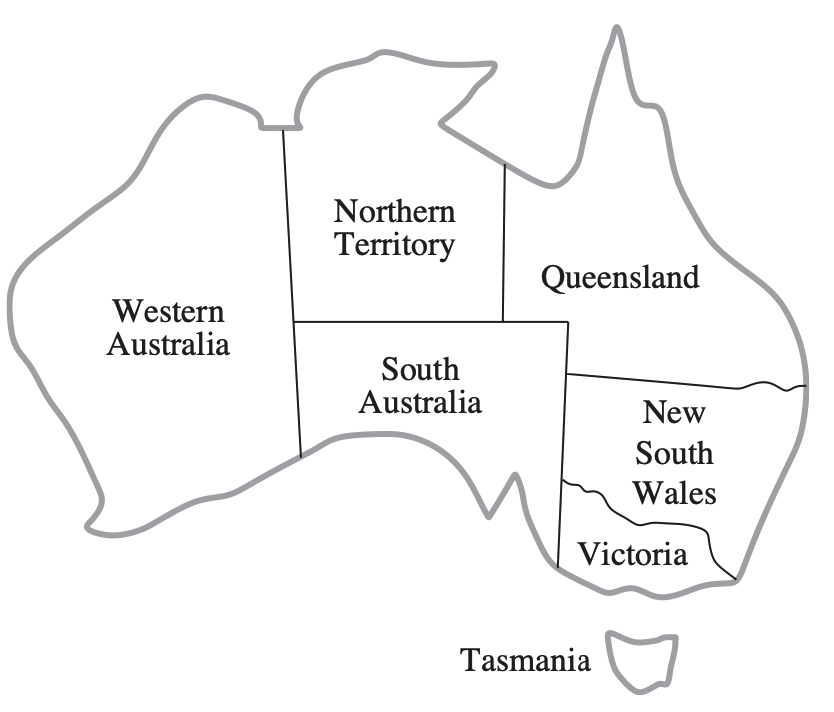

In [19]:
from IPython.display import Image
Image(filename='images/map.png') 

In [20]:
variables = ['WA', 'NT', 'Q', 'NSW', 'V', 'SA', 'T']
domains = {var: ['red', 'blue', 'green'] for var in variables}

class DifferentValues:
    def __init__(self, var1, var2):
        self.var1 = var1
        self.var2 = var2
        
    def check(self, assignment):
        value1 = assignment.get(self.var1)
        value2 = assignment.get(self.var2)
        if value1 and value2:
            return value1 != value2
        return True
    
constraints = [
    DifferentValues('SA', 'WA'),
    DifferentValues('SA', 'NT'),
    DifferentValues('SA', 'Q'),
    DifferentValues('SA', 'NSW'),
    DifferentValues('SA', 'V'),
    DifferentValues('WA', 'NT'),
    DifferentValues('NT', 'Q'),
    DifferentValues('Q', 'NSW'),
    DifferentValues('NSW', 'V')
]

csp = CSP(variables, domains, constraints)

print(csp.assign({}, 'SA', 'green'))
print(csp.unassign({'SA': 'green'}, 'SA'))
print(csp.complete({'SA': 'green'}))
print(csp.consistent({'SA': 'green'}))
c = DifferentValues('SA', 'V')
print(c.check({'SA': 'green', 'V': 'green'}))
print(c.check({'SA': 'green'}))


{'SA': 'green'}
{}
False
True
False
True


## Backtracking Search

Backtracking search is a depth-first search (recursive) that selects values for one variable at a time and backtracks when no legal value can be assigned.  

1. Choose a variable to assign.  
2. Choose a value to assign.  
3. Check for inconsistencies; if found, backtrack.  

Like local search, we are only interested in configurations that represent a solution, so we maintain a single representation of the state at any given time.  

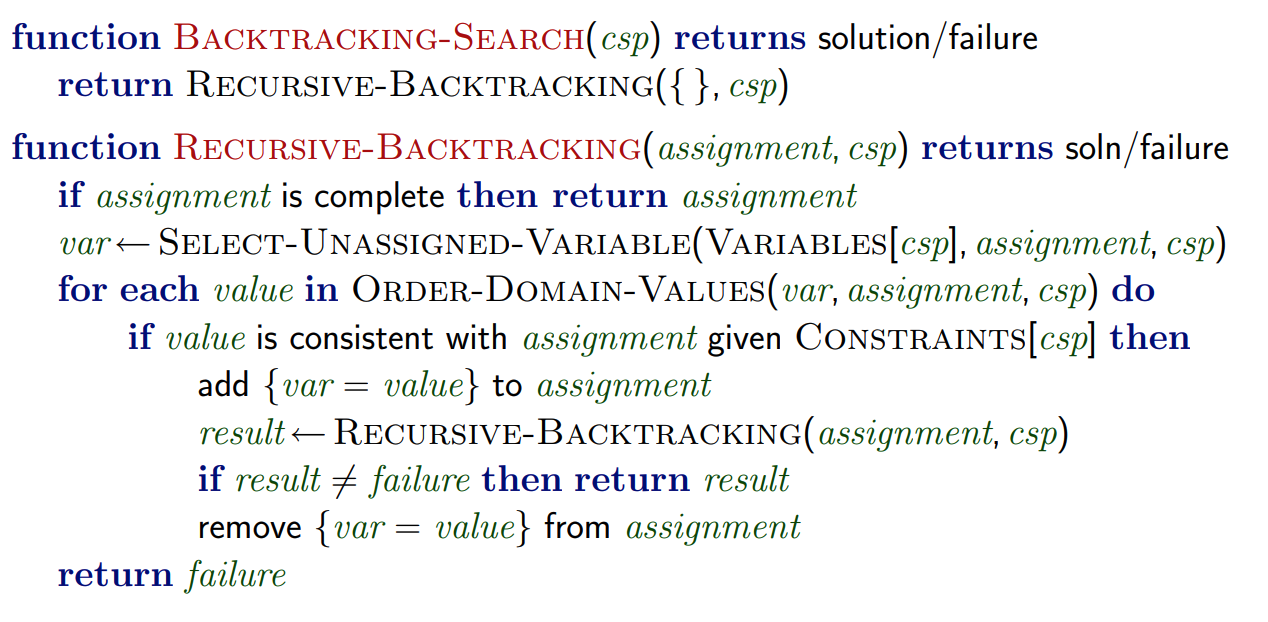

In [21]:
from IPython.display import Image
Image(filename='images/backtracking.png') 

In [22]:
class Backtracking:
    def __init__(self, csp, variable_criterion, value_criterion):
        self.csp = csp
        self.variable_criterion = variable_criterion
        self.value_criterion = value_criterion
        
    def recursive_backtracking(self, assignment):
        # base case
        if self.csp.complete(assignment) and self.csp.consistent(assignment):
            return assignment
        
        variable = self.variable_criterion(self.csp, assignment)
       
        for value in self.value_criterion(self.csp, variable, assignment):
            self.csp.assign(assignment, variable, value)
            
            if self.csp.consistent(assignment):
                result = self.recursive_backtracking(assignment)
                
                if result:
                    return result
                
            self.csp.unassign(assignment, variable)
            
        return False    
        
    def run(self):
        return self.recursive_backtracking({})

We can now test our implementation on the map coloring problem. To do so, we implement two heuristics for selecting variables and values.  

In [23]:
import random

def random_variables(csp, assignment):
    return random.choice([var for var in csp.variables if var not in assignment.keys()])

def unordered_value(csp, variable, assigment):
    return csp.domains[variable]
    
search = Backtracking(csp, variable_criterion=random_variables, value_criterion=unordered_value)
print(search.run())

{'Q': 'red', 'SA': 'blue', 'WA': 'red', 'V': 'red', 'T': 'red', 'NSW': 'green', 'NT': 'green'}


## Heuristics

Using heuristics can significantly improve the efficiency of CSP search by guiding variable selection and value assignment.  

- **Variable ordering:** The choice of which variable to assign first can impact the search process.  
  - **Minimum-remaining-values (MRV):** Prioritize variables with the fewest legal values remaining to detect failures early
  - **Degree heuristic:** Select the variable involved in the most constraints with unassigned variables to reduce the branching factor 

- **Value ordering:** The order in which values are assigned affects constraint propagation
  - **Least-constraining-value:** Prefer values that leave the most options open for remaining variables, reducing the likelihood of early failure

These heuristics help optimize the search, but if no solution exists or if all solutions must be found, their impact is minimal.  



In [24]:
def minimum_remaining_values(csp, assignment):
    unassigned_variables = [v for v in csp.variables if v not in assignment.keys()]
    return min(unassigned_variables, key = lambda v: len(csp.domains[v]))


def degree_heuristic(csp, assignment):
    unassigned_variables = [v for v in csp.variables if v not in assignment.keys()]
    constraints_count = {v: 0 for v in unassigned_variables}
    
    for c in csp.constraints:
        if c.var1 in unassigned_variables and c.var2 in unassigned_variables:
            constraints_count[c.var1]  += 1
            constraints_count[c.var2]  += 1
            
    return max(unassigned_variables, key = lambda v: constraints_count[v])


def least_constraining_value(csp, variable, assignment):
    #TODO: da controllare questa funzione
    
    def removed_values(variable, value):
        count = 0
        unassigned_variables = [v for v in csp.variables if v not in assignment.keys()]
        
        for var in unassigned_variables:
            count += sum(1 for val in csp.domains[var] if not csp.consistent({**assignment, variable: value, var: val}))
            
        return count
    
    order = sorted(csp.domains[variable], key= lambda value: removed_values(variable, value)) 
    return order

    
search = Backtracking(csp, variable_criterion=degree_heuristic, value_criterion=unordered_value)
print(search.run())

search = Backtracking(csp, variable_criterion=minimum_remaining_values, value_criterion=unordered_value)
print(search.run())

search = Backtracking(csp, variable_criterion=minimum_remaining_values, value_criterion=least_constraining_value)
print(search.run())

{'SA': 'red', 'NT': 'blue', 'NSW': 'blue', 'WA': 'green', 'Q': 'green', 'V': 'green', 'T': 'red'}
{'WA': 'red', 'NT': 'blue', 'Q': 'red', 'NSW': 'blue', 'V': 'red', 'SA': 'green', 'T': 'red'}
{'WA': 'red', 'NT': 'blue', 'Q': 'red', 'NSW': 'blue', 'V': 'red', 'SA': 'green', 'T': 'red'}


# Inference


Other than searching, we can do a type of inference called **constraint propagation**: using constraints to reduce the number of legal values for a variable, which can, in turn, reduce the legal values for another variable, and so on.  

This process can be applied as **preprocessing** or during the search. In some cases, preprocessing alone can directly solve the problem.

## CSP Implementation

To perform inference, we need to modify our CSP class to include the neighbors of each variable, which are the other variables connected by a constraint.

In [25]:
class CSP:
    def __init__(self, variables, domains, constraints):
        self.variables = variables
        self.domains = domains
        self.constraints = constraints
        self.neighbors = self.compute_neighbors()
        
    def compute_neighbors(self):
        neighbors = {}
        for c in self.constraints:
            neighbors.setdefault(c.var1, []).append(c.var2)
            neighbors.setdefault(c.var2, []).append(c.var1)
        return neighbors
        
    def assign(self, assignment, variable, value):
        assignment[variable] = value
        return assignment
        
    def unassign(self, assignment, variable):
        assignment.pop(variable)
        return assignment
    
    def complete(self, assigment):
        return len(assigment) == len(self.variables)
    
    def consistent(self, assignment):
        return all([constraint.check(assignment) for constraint in self.constraints])

## AC-3

A variable is **arc-consistent** if every value in its domain satisfies all binary constraints involving that variable.  

The most commonly used algorithm for enforcing arc consistency is **AC-3**. It maintains a queue of arcs to process, ensuring consistency iteratively.  

1. **Initialization**: The queue starts with all arcs in the CSP.  
2. **Processing an arc** $ (X_i, X_j) $:  
   - Make $ X_i $ arc-consistent with $ X_j $.  
   - If $ D_i $ remains unchanged, proceed to the next arc.  
   - If $ D_i $ is modified, add all arcs $ (X_k, X_i) $ to the queue, where $ X_k $ is a neighbor of $ X_i $.  
   - If $ D_i $ becomes empty, the CSP has no solution, and the algorithm returns failure.  

The process repeats until either failure is detected or no more arcs remain in the queue. If AC-3 terminates without failure, the CSP is reduced but retains the same solutions as the original.  

AC-3 runs in $O(cd^3)$ time, where $c$ is the number of constraints and $d$ is the domain size.  


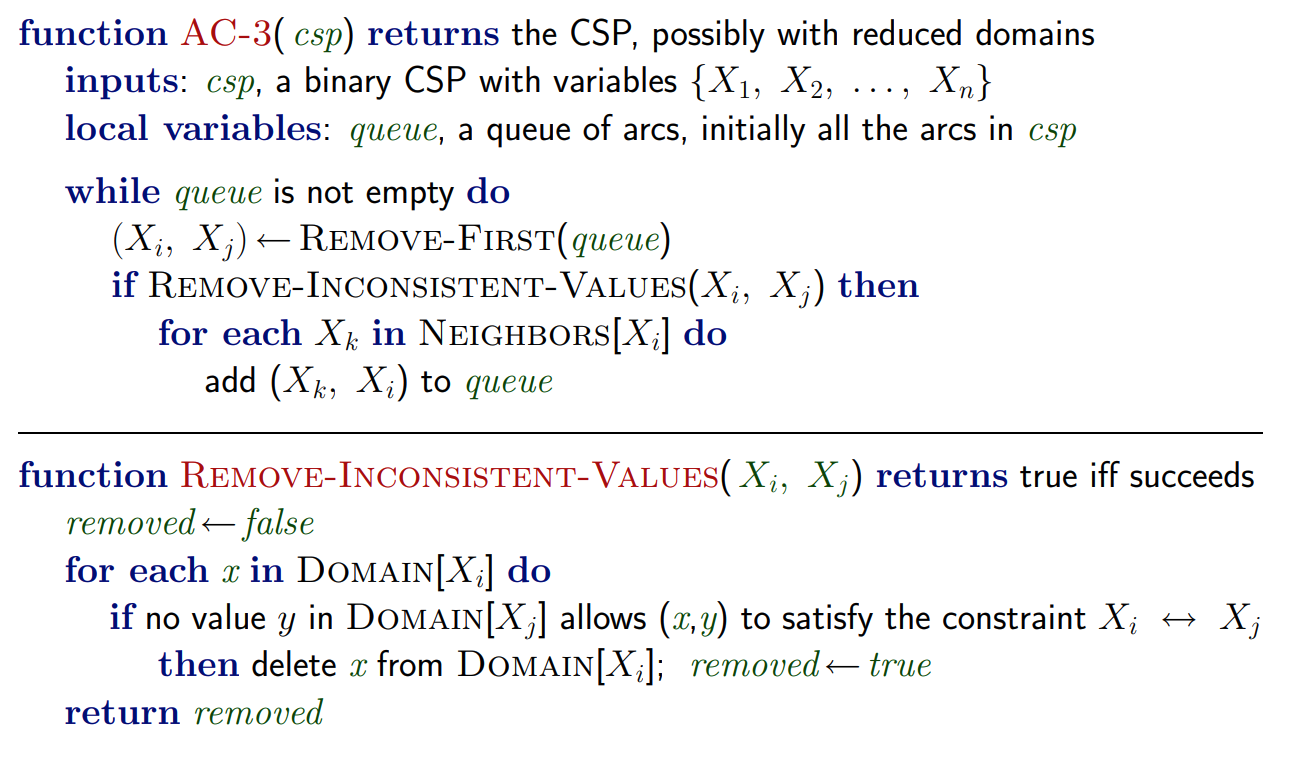

In [26]:
from IPython.display import Image
Image(filename='images/ac3.png') 

In [27]:
class AC3:
    def __init__(self, csp):
        self.csp = csp
        self.queue = self.arcs()

    def arcs(self):
        arcs = []
        for var in self.csp.neighbors.keys():
            arcs += [(var, neighbor) for neighbor in self.csp.neighbors[var]]
        return arcs
        
    def remove_inconsistent_value(self, x_i, x_j):
        removed = False
        for v_i in self.csp.domains[x_i][:]:
            constraints_results = [self.csp.consistent({x_i: v_i, x_j: v_j}) for v_j in self.csp.domains[x_j]]
            if not any(constraints_results):
                removed = True
                self.csp.domains[x_i].remove(v_i)
        return removed
    
    def run(self):
        while self.queue:
            x_i, x_j = self.queue.pop(0)
            if self.remove_inconsistent_value(x_i, x_j):
                if len(self.csp.domains[x_i]) == 0:
                    return False
                for x_k in self.csp.neighbors[x_i]:
                    self.queue += [(x_k, x_i)]
        return True


### Example Problem: Toy Problem ($Y = X^2$)

Let's consider the constraint $Y = X^2$, where both $X$ and $Y$ have the domain of digits $(\{0,1,2,3,4,5,6,7,8,9\}$. 

We can explicitly represent this constraint as the set of valid pairs:

$$
(X, Y) \in \{(0,0), (1,1), (2,4), (3,9)\}
$$

To make $X$ arc-consistent with respect to $Y$, we remove all values from $X$'s domain that do not have a corresponding valid value in $Y$, resulting in:

$$
D(X) = \{0,1,2,3\}
$$

Similarly, making $Y$ arc-consistent with respect to $X$ gives us:

$$
D(Y) = \{0,1,4,9\}
$$

At this point, the CSP is fully arc-consistent.


In [28]:
class SquareValue:
    def __init__(self, var1, var2):
        self.var1 = var1
        self.var2 = var2

    def check(self, assignment):
        if self.var1 in assignment and self.var2 in assignment:
            val1 = assignment.get(self.var1)
            val2 = assignment.get(self.var2)
            return val1 == (val2 ** 2)
        return True

csp = CSP(['X', 'Y'], {'X': [i for i in range(10)], 'Y': [i for i in range(10)]}, [SquareValue('Y','X')])
ac3 = AC3(csp)
print(ac3.csp.domains)
ac3.run()
#ac3.remove_inconsistent_value('X', 'Y')
#ac3.remove_inconsistent_value('Y', 'X')
print(ac3.csp.domains)

{'X': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'Y': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}
{'X': [0, 1, 2, 3], 'Y': [0, 1, 4, 9]}


### Example Problem: Map Coloring

Arc-consistency does not always reduce variable domains. Consider the map coloring problem: since each region has three available colors and every color has at least one valid alternative for its neighbors, the arc-consistency algorithm cannot eliminate any values. As a result, AC-3 preprocessing has no effect on the domains.


In [29]:
variables = ['WA', 'NT', 'Q', 'NSW', 'V', 'SA', 'T']
domains = {var: ['red', 'blue', 'green'] for var in variables}


class DifferentValues:
    def __init__(self, var1, var2):
        self.var1 = var1
        self.var2 = var2
        
    def check(self, assignment):
        value1 = assignment.get(self.var1)
        value2 = assignment.get(self.var2)
        if value1 and value2:
            return value1 != value2
        return True
    
constraints = [
    DifferentValues('SA', 'WA'),
    DifferentValues('SA', 'NT'),
    DifferentValues('SA', 'Q'),
    DifferentValues('SA', 'NSW'),
    DifferentValues('SA', 'V'),
    DifferentValues('WA', 'NT'),
    DifferentValues('NT', 'Q'),
    DifferentValues('Q', 'NSW'),
    DifferentValues('NSW', 'V')
]

csp = CSP(variables, domains, constraints)
ac3 = AC3(csp)
print(ac3.csp.domains)
ac3.run()
print(ac3.csp.domains)

{'WA': ['red', 'blue', 'green'], 'NT': ['red', 'blue', 'green'], 'Q': ['red', 'blue', 'green'], 'NSW': ['red', 'blue', 'green'], 'V': ['red', 'blue', 'green'], 'SA': ['red', 'blue', 'green'], 'T': ['red', 'blue', 'green']}
{'WA': ['red', 'blue', 'green'], 'NT': ['red', 'blue', 'green'], 'Q': ['red', 'blue', 'green'], 'NSW': ['red', 'blue', 'green'], 'V': ['red', 'blue', 'green'], 'SA': ['red', 'blue', 'green'], 'T': ['red', 'blue', 'green']}


## Forward Checking

Inference can also be done **during** the search: every time we assign a value to a variable, we gain a new opportunity to infer domain reductions for neighboring variables.

One of the simplest forms of inference during search is **forward checking**. When a variable $X$ is assigned a value, forward checking enforces arc consistency for it: for each unassigned variable $Y$ connected to $X$ by a constraint, we remove from $Y$'s domain any value that is inconsistent with the chosen value of $X$.

In [30]:
import copy

class BacktrackingWithFC:
    def __init__(self, csp, variable_criterion, value_criterion):
        self.csp = csp
        self.variable_criterion = variable_criterion
        self.value_criterion = value_criterion

    def forward_check(self, assignment, variable):
        new_domain = copy.deepcopy(self.csp.domains)

        for var in self.csp.variables:
            new_assignment = copy.deepcopy(assignment)
            if var not in new_assignment and var in self.csp.neighbors.get(variable, []):
                for value in new_domain[var][:]:
                    self.csp.assign(new_assignment, var, value)
                    if not self.csp.consistent(new_assignment):
                        new_domain[var].remove(value)
                        print(f'New domain: {new_domain[var]}')
                        
                if len(new_domain[var]) == 0:
                    print(f'Empty Domain of {var}')
                    return False
        return True
    

    def recursive_backtracking(self, assignment):
        
        # Base case
        if self.csp.complete(assignment) and self.csp.consistent(assignment):
            return assignment
        
        variable = self.variable_criterion(self.csp, assignment)
        
        for value in self.value_criterion(self.csp, variable, assignment):
            self.csp.assign(assignment, variable, value)
            
            if self.forward_check(assignment, variable) and self.csp.consistent(assignment):
                result = self.recursive_backtracking(assignment)
                
                if result:
                    return result

            self.csp.unassign(assignment, variable)
            
        return False

    def run(self):
        return self.recursive_backtracking({})

We can now try our implementation:

In [31]:
search = BacktrackingWithFC(csp, variable_criterion=random_variables, value_criterion=unordered_value)
print(search.run())

New domain: ['blue', 'green']
New domain: ['blue', 'green']
New domain: ['blue', 'green']
New domain: ['blue', 'green']
New domain: ['blue', 'green']
New domain: ['blue', 'green']
New domain: ['green']
New domain: []
Empty Domain of NSW
New domain: ['blue', 'green']
New domain: ['green']
New domain: ['blue', 'green']
New domain: ['green']
New domain: ['blue', 'green']
New domain: ['green']
New domain: []
Empty Domain of WA
New domain: ['blue', 'green']
New domain: ['green']
New domain: []
Empty Domain of WA
New domain: ['blue', 'green']
New domain: ['blue']
New domain: ['blue', 'green']
New domain: ['green']
New domain: []
Empty Domain of NSW
New domain: ['blue', 'green']
New domain: ['blue']
New domain: ['blue', 'green']
New domain: ['blue']
New domain: ['blue', 'green']
New domain: ['green']
New domain: []
Empty Domain of WA
New domain: ['blue', 'green']
New domain: ['green']
New domain: ['blue', 'green']
New domain: ['green']
New domain: []
Empty Domain of NSW
New domain: ['blue', '

# Local Search for CSP

Local search algorithms are particularly effective for solving many constraint satisfaction problems. By starting from a complete assignment of variables, they iteratively make small changes, typically modifying the value of one variable at a time, to reduce the number of constraint violations. 

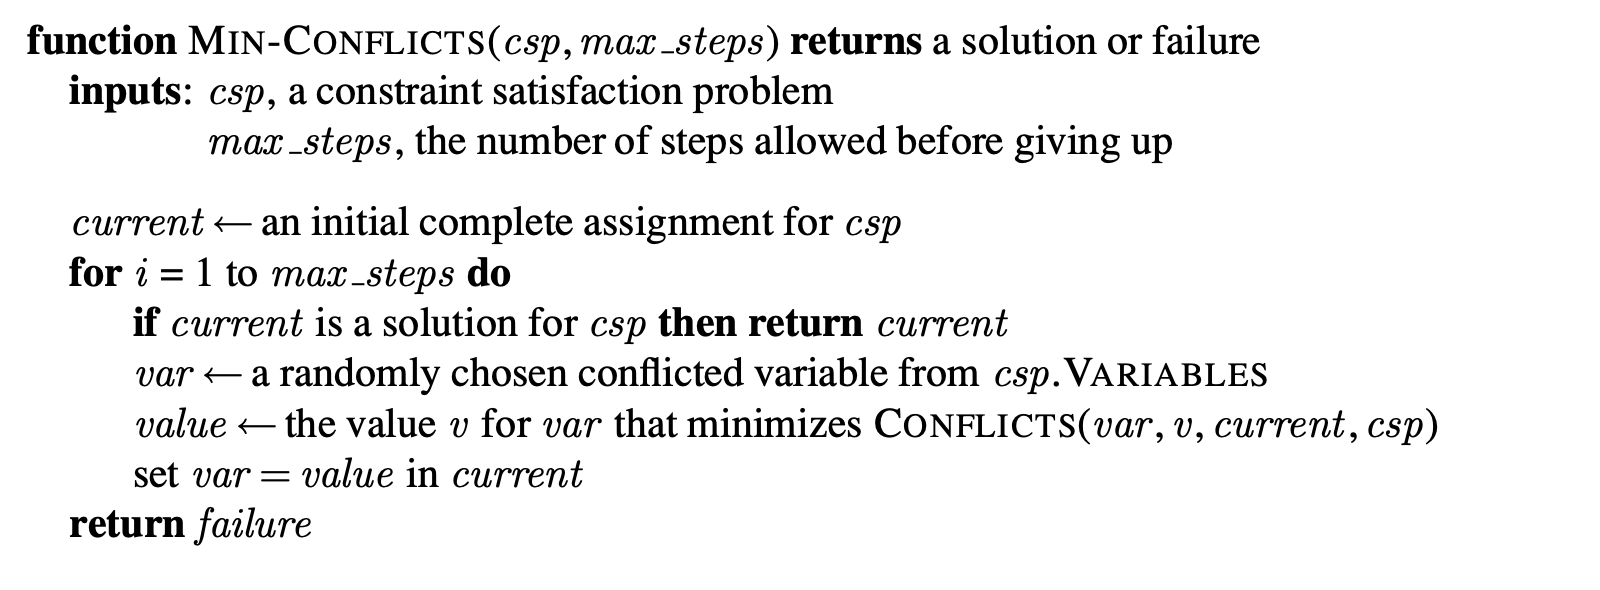

In [32]:
from IPython.display import Image
Image(filename='images/min_conflict.png') 

In [33]:
class MinConflicts:
    def __init__(self, csp, max_steps):
        self.csp = csp
        self.max_steps = max_steps
        
    def n_conflicts(self, current, variable, value):
        count = 0
        
        for constraint in self.csp.constraints:
            if variable in {constraint.var1, constraint.var2} and not constraint.check({**current, variable: value}):
                count += 1
                
        return count
        
    def run(self):
        current = {var: random.choice(self.csp.domains[var]) for var in self.csp.variables}
        
        for i in range(self.max_steps):
            if self.csp.consistent(current):
                return current
            
            conflicted_variables = [var for var in self.csp.variables if self.n_conflicts(current, var, current[var]) > 0]
            print(f'Conflicted: {conflicted_variables}')
            
            var = random.choice(conflicted_variables)
            print(f'Chosen variable: {var}')
            
            val = min(self.csp.domains[var], key= lambda val: self.n_conflicts(current, var, val))
            print(f'Chosen value: {val}')
            
            current[var] = val
            print(f'Current Assignment: {current})')
    
        return False

In [34]:
local_search = MinConflicts(csp, 50)
print(f'Local Search Result: {local_search.run()}')

Conflicted: ['WA', 'NT', 'Q', 'NSW', 'SA']
Chosen variable: Q
Chosen value: red
Current Assignment: {'WA': 'green', 'NT': 'green', 'Q': 'red', 'NSW': 'blue', 'V': 'green', 'SA': 'blue', 'T': 'red'})
Conflicted: ['WA', 'NT', 'NSW', 'SA']
Chosen variable: WA
Chosen value: red
Current Assignment: {'WA': 'red', 'NT': 'green', 'Q': 'red', 'NSW': 'blue', 'V': 'green', 'SA': 'blue', 'T': 'red'})
Conflicted: ['NSW', 'SA']
Chosen variable: NSW
Chosen value: red
Current Assignment: {'WA': 'red', 'NT': 'green', 'Q': 'red', 'NSW': 'red', 'V': 'green', 'SA': 'blue', 'T': 'red'})
Conflicted: ['Q', 'NSW']
Chosen variable: NSW
Chosen value: red
Current Assignment: {'WA': 'red', 'NT': 'green', 'Q': 'red', 'NSW': 'red', 'V': 'green', 'SA': 'blue', 'T': 'red'})
Conflicted: ['Q', 'NSW']
Chosen variable: Q
Chosen value: red
Current Assignment: {'WA': 'red', 'NT': 'green', 'Q': 'red', 'NSW': 'red', 'V': 'green', 'SA': 'blue', 'T': 'red'})
Conflicted: ['Q', 'NSW']
Chosen variable: Q
Chosen value: red
Current